# Multivariable prediction with LSTM network

The purpose of this document is to show the procedure for using the LSTM network with more than one variable as input. In this case, we are trying to predict Apple's "Close" value, based on the "Open", "High" and "Low" values, and the Volume operation. 

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
df = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date']) # read data 
df = df.drop("Name", axis = 1)
df

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036
2006-01-04,10.73,10.85,10.64,10.71,155225609
2006-01-05,10.69,10.70,10.54,10.63,112396081
2006-01-06,10.75,10.96,10.65,10.90,176139334
2006-01-09,10.96,11.03,10.82,10.86,168861224
...,...,...,...,...,...
2017-12-22,174.68,175.42,174.50,175.01,16349444
2017-12-26,170.80,171.47,169.68,170.57,33185536
2017-12-27,170.10,170.78,169.71,170.60,21498213


In [3]:
test_size = int(len(df) * 0.1) # here I said that the test data will be 10% (0.1) of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [4]:
train

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036
2006-01-04,10.73,10.85,10.64,10.71,155225609
2006-01-05,10.69,10.70,10.54,10.63,112396081
2006-01-06,10.75,10.96,10.65,10.90,176139334
2006-01-09,10.96,11.03,10.82,10.86,168861224
...,...,...,...,...,...
2016-10-13,116.79,117.44,115.72,116.98,35192406
2016-10-14,117.88,118.17,117.13,117.63,35652191
2016-10-17,117.33,117.84,116.78,117.55,23624896


In [5]:
test

,Open,High,Low,Close,Volume
Date,,,,,
2016-10-20,116.86,117.38,116.33,117.06,24125801
2016-10-21,116.81,116.91,116.28,116.60,23192665
2016-10-24,117.10,117.74,117.00,117.65,23538673
2016-10-25,117.95,118.36,117.31,118.25,48128970
2016-10-26,114.31,115.70,113.31,115.59,66134219
...,...,...,...,...,...
2017-12-22,174.68,175.42,174.50,175.01,16349444
2017-12-26,170.80,171.47,169.68,170.57,33185536
2017-12-27,170.10,170.78,169.71,170.60,21498213


In [6]:
X_train = train.drop("Close",axis=1).copy()
y_train = train[["Close"]].copy() # the double brakets here are to keep the y in dataframe format, otherwise it will be pandas Series
print(X_train.shape, y_train.shape)

(2718, 4) (2718, 1)


In [7]:
X_train

,Open,High,Low,Volume
Date,,,,
2006-01-03,10.34,10.68,10.32,201853036
2006-01-04,10.73,10.85,10.64,155225609
2006-01-05,10.69,10.70,10.54,112396081
2006-01-06,10.75,10.96,10.65,176139334
2006-01-09,10.96,11.03,10.82,168861224
...,...,...,...,...
2016-10-13,116.79,117.44,115.72,35192406
2016-10-14,117.88,118.17,117.13,35652191
2016-10-17,117.33,117.84,116.78,23624896


In [8]:
y_train

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86
...,...
2016-10-13,116.98
2016-10-14,117.63
2016-10-17,117.55


In [9]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_X_train.shape, scaled_y_train.shape)

(2718, 4) (2718,)


In [10]:
scaled_X_train

array([[0.02321555, 0.0245708 , 0.02535619, 0.22742073],
       [0.02628472, 0.02590959, 0.02793206, 0.17125802],
       [0.02596994, 0.0247283 , 0.0271271 , 0.11966987],
       ...,
       [0.86519241, 0.86848323, 0.88231506, 0.01274502],
       [0.87188164, 0.87139707, 0.88770828, 0.0138635 ],
       [0.86456284, 0.86785321, 0.8583273 , 0.0084205 ]])

In [11]:
scaled_y_train

array([0.02735369, 0.02759224, 0.02695611, ..., 0.87714695, 0.87651081,
       0.87372774])

In [12]:
# move "y" one place in the array, and delete the last value of it
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

In [13]:
scaled_y_train

array([0.        , 0.02735369, 0.02759224, ..., 0.87778308, 0.87714695,
       0.87651081])

In [14]:
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size) #The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models 

In [15]:
generator.data

array([[0.02321555, 0.0245708 , 0.02535619, 0.22742073],
       [0.02628472, 0.02590959, 0.02793206, 0.17125802],
       [0.02596994, 0.0247283 , 0.0271271 , 0.11966987],
       ...,
       [0.86519241, 0.86848323, 0.88231506, 0.01274502],
       [0.87188164, 0.87139707, 0.88770828, 0.0138635 ],
       [0.86456284, 0.86785321, 0.8583273 , 0.0084205 ]])

In [16]:
generator.data.shape

(2718, 4)

In [17]:
generator.targets

array([0.        , 0.02735369, 0.02759224, ..., 0.87778308, 0.87714695,
       0.87651081])

In [18]:
generator.targets.shape

(2718,)

In [19]:
generator[0][0].shape # The shape should be (batch_size,n_input,n_features)

(32, 25, 4)

In [20]:
# 1st example

model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [21]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
85/85 [==============================] - 10s 114ms/step - loss: 0.0548 - mean_absolute_error: 0.0547
Epoch 2/5
85/85 [==============================] - 5s 61ms/step - loss: 0.0215 - mean_absolute_error: 0.0214: 2s
Epoch 3/5
85/85 [==============================] - 5s 62ms/step - loss: 0.0157 - mean_absolute_error: 0.0155: 3s - loss: 0.0178 - mean_a - ETA: 2s - loss: 0.0159 - mean_absolute_e - ETA: 1s - loss: 0.0160 - mean_absolute_ - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.0 - ETA: 0s - loss: 0.0167 - mean_absolute_erro
Epoch 4/5
85/85 [==============================] - 4s 53ms/step - loss: 0.0143 - mean_absolute_error: 0.0139
Epoch 5/5
85/85 [==============================] - 5s 61ms/step - loss: 0.0129 - mean_absolute_error: 0.0129: 1s - loss: 0.0109 - mean_ab


In [22]:
X_test = test.drop("Close",axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

In [23]:
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test["Close"].values[n_input:],'y_pred':y_pred.ravel()})

In [24]:
results

,y_true,y_pred
0,111.79,111.377937
1,111.57,111.707062
2,111.46,112.000008
3,110.52,112.071968
4,109.49,112.218201
...,...,...
271,175.01,176.587082
272,170.57,176.866943
273,170.60,176.002304
274,171.08,175.354095


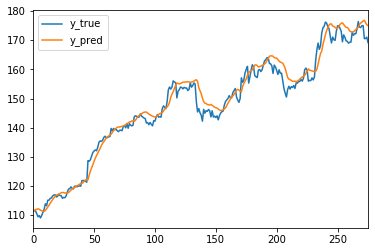

In [25]:
results.plot()

In [26]:
mean_squared_error(test["Close"].values[n_input:], y_pred)

8.774066479665077

Epoch 1/5
84/84 [==============================] - 10s 124ms/step - loss: 0.0418 - mean_absolute_error: 0.0415
Epoch 2/5
84/84 [==============================] - 9s 111ms/step - loss: 0.0156 - mean_absolute_error: 0.0153
Epoch 3/5
84/84 [==============================] - 10s 114ms/step - loss: 0.0173 - mean_absolute_error: 0.0173
Epoch 4/5
84/84 [==============================] - 10s 114ms/step - loss: 0.0147 - mean_absolute_error: 0.0147
Epoch 5/5
84/84 [==============================] - 10s 125ms/step - loss: 0.0142 - mean_absolute_error: 0.0140


,y_true,y_pred
0,116.15,115.680061
1,116.02,115.446304
2,116.61,115.399529
3,117.91,115.382706
4,118.99,115.581123
...,...,...
246,175.01,172.929825
247,170.57,173.195526
248,170.60,172.205353
249,171.08,171.468674


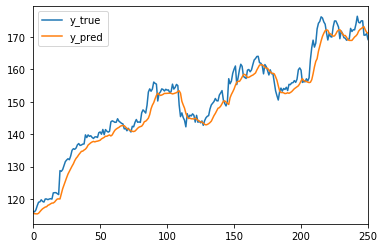

In [27]:
# 2nd example. I increase the number of n_input from 25 to 50 and create a hidden Dense layer.

n_input = 50 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size) #The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models

model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(1, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit_generator(generator,epochs=5)

X_test = test.drop("Close",axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test["Close"].values[n_input:],'y_pred':y_pred.ravel()})

results.plot()
results

In [28]:
mean_squared_error(test["Close"].values[n_input:], y_pred)

11.123620585158198

Epoch 1/5
85/85 [==============================] - 8s 90ms/step - loss: 0.0688 - mean_absolute_error: 0.0685
Epoch 2/5
85/85 [==============================] - 5s 63ms/step - loss: 0.0269 - mean_absolute_error: 0.0272
Epoch 3/5
85/85 [==============================] - 6s 67ms/step - loss: 0.0152 - mean_absolute_error: 0.0149
Epoch 4/5
85/85 [==============================] - 6s 69ms/step - loss: 0.0215 - mean_absolute_error: 0.0214
Epoch 5/5
85/85 [==============================] - 5s 60ms/step - loss: 0.0187 - mean_absolute_error: 0.0188


,y_true,y_pred
0,111.79,109.764687
1,111.57,110.138832
2,111.46,110.441887
3,110.52,110.444847
4,109.49,110.533791
...,...,...
271,175.01,174.956085
272,170.57,175.252472
273,170.60,174.195831
274,171.08,173.419250


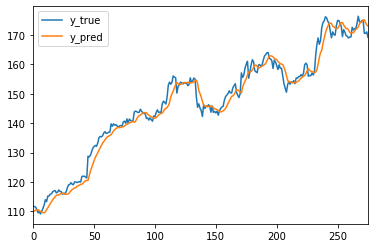

In [29]:
# 3rd example. I returned n_input to 25 and increase the number of neurons of the hidden layer to 200.

n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size) #The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models

model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(200, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit_generator(generator,epochs=5)

X_test = test.drop("Close",axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test["Close"].values[n_input:],'y_pred':y_pred.ravel()})

results.plot()
results

In [30]:
mean_squared_error(test["Close"].values[n_input:], y_pred)

7.939756572090363

Epoch 1/5
85/85 [==============================] - 8s 99ms/step - loss: 0.0627 - mean_absolute_error: 0.0625
Epoch 2/5
85/85 [==============================] - 6s 69ms/step - loss: 0.0607 - mean_absolute_error: 0.0611
Epoch 3/5
85/85 [==============================] - 6s 74ms/step - loss: 0.0762 - mean_absolute_error: 0.0750
Epoch 4/5
85/85 [==============================] - 6s 66ms/step - loss: 0.0360 - mean_absolute_error: 0.0357
Epoch 5/5
85/85 [==============================] - 6s 74ms/step - loss: 0.0270 - mean_absolute_error: 0.0270


,y_true,y_pred
0,111.79,97.813133
1,111.57,98.171585
2,111.46,98.433464
3,110.52,98.396011
4,109.49,98.444649
...,...,...
271,175.01,154.830872
272,170.57,155.068100
273,170.60,153.938599
274,171.08,153.200348


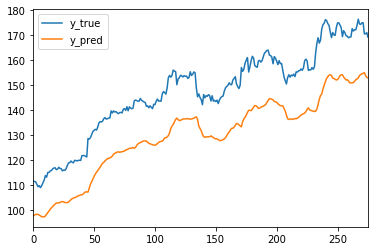

In [31]:
# 4th. I create three more hidden layers with 300 neurons.

n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size) #The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models

model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(200, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit_generator(generator,epochs=5)

X_test = test.drop("Close",axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test["Close"].values[n_input:],'y_pred':y_pred.ravel()})

results.plot()
results

In [32]:
mean_squared_error(test["Close"].values[n_input:], y_pred)

304.48884382311627

Epoch 1/10
85/85 [==============================] - 8s 96ms/step - loss: 0.0707 - mean_absolute_error: 0.0709
Epoch 2/10
85/85 [==============================] - 6s 73ms/step - loss: 0.0179 - mean_absolute_error: 0.0177
Epoch 3/10
85/85 [==============================] - 5s 63ms/step - loss: 0.0186 - mean_absolute_error: 0.0186
Epoch 4/10
85/85 [==============================] - 6s 72ms/step - loss: 0.0156 - mean_absolute_error: 0.0158
Epoch 5/10
85/85 [==============================] - 6s 73ms/step - loss: 0.0169 - mean_absolute_error: 0.0167
Epoch 6/10
85/85 [==============================] - 5s 64ms/step - loss: 0.0157 - mean_absolute_error: 0.0157
Epoch 7/10
85/85 [==============================] - 6s 73ms/step - loss: 0.0166 - mean_absolute_error: 0.0166
Epoch 8/10
85/85 [==============================] - 6s 68ms/step - loss: 0.0107 - mean_absolute_error: 0.0107
Epoch 9/10
85/85 [==============================] - 6s 71ms/step - loss: 0.0211 - mean_absolute_error: 0.0212
Epoch 10/1

,y_true,y_pred
0,111.79,105.772354
1,111.57,106.115753
2,111.46,106.370796
3,110.52,106.341385
4,109.49,106.426086
...,...,...
271,175.01,166.177246
272,170.57,166.397263
273,170.60,165.189545
274,171.08,164.397491


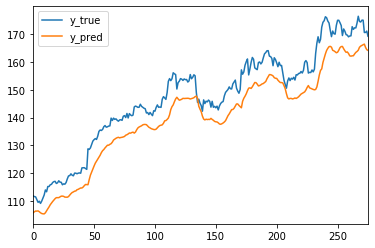

In [33]:
# 5th example. I returned to example 3 and increase the number of epochs to 10

n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size) #The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models

model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(200, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit_generator(generator,epochs=10)

X_test = test.drop("Close",axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test["Close"].values[n_input:],'y_pred':y_pred.ravel()})

results.plot()
results

In [34]:
mean_squared_error(test["Close"].values[n_input:], y_pred)

59.84458318027

Epoch 1/10
135/135 [==============================] - 11s 84ms/step - loss: 0.0547 - mean_absolute_error: 0.0548- ETA: 3s - loss: 0.0669 - - ETA: 0s - loss: 0.0566 - mean_absolute_error:
Epoch 2/10
135/135 [==============================] - 8s 59ms/step - loss: 0.0157 - mean_absolute_error: 0.0158
Epoch 3/10
135/135 [==============================] - 9s 64ms/step - loss: 0.0230 - mean_absolute_error: 0.0229
Epoch 4/10
135/135 [==============================] - 8s 60ms/step - loss: 0.0253 - mean_absolute_error: 0.0250:  - ETA: 2s - loss: 0.0 - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.025
Epoch 5/10
135/135 [==============================] - 9s 63ms/step - loss: 0.0120 - mean_absolute_error: 0.0120
Epoch 6/10
135/135 [==============================] - 9s 65ms/step - loss: 0.0233 - mean_absolute_error: 0.0231
Epoch 7/10
135/135 [==============================] - 9s 65ms/step - loss: 0.0195 - mean_absolute_error: 0.0193
Epoch 8/10
135/135 [==============================] - 9s 69ms/s

,y_true,y_pred
0,111.79,110.981964
1,111.57,111.306740
2,111.46,111.535400
3,110.52,111.401718
4,109.49,111.458191
...,...,...
271,175.01,172.208099
272,170.57,172.366562
273,170.60,170.743011
274,171.08,169.744110


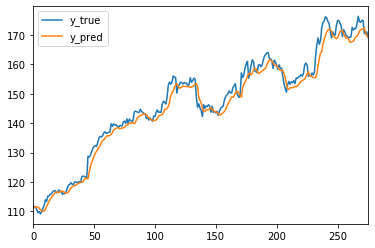

In [35]:
# 6th example. The same as number 5, but with batch_size 20.

n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 20 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size) #The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models

model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model.add(Dense(200, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit_generator(generator,epochs=10)

X_test = test.drop("Close",axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test["Close"].values[n_input:],'y_pred':y_pred.ravel()})

results.plot()
results

In [36]:
mean_squared_error(test["Close"].values[n_input:], y_pred)

7.962582949729587